## CSCA 5632 Final Project: Sentiment analysis in IMDB Movie Ratings database

### Introduction and Why?
Sentiment analysis is a staple project in the world of machine learning. It has numerous applications, including PR / customer service, training AI to detect user emotion, market research, stock market forcasting, and content moderation.  Of course, it's also a great opportunity to employ the unsupervised learning methods that we explored in this class and see how they perform.

### Data
The IMDB Movie Ratings database is a great resource for us, as it has 40,000 text-based reviews that are labeled with positive/negative, which we can use to check our accuracy.

**Original data source:**
_Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, 142-150. Stanford AI Lab. Retrieved from https://ai.stanford.edu/~amaas/data/sentiment/_

#### Features / factors
1. reviews
The plaintext content of the review.

2. sentiment
A binary positive/negative category designation


#### Library Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
import os
import zipfile

#### Data Import

In [5]:
# Import the database
df = pd.read_csv('./imdb.csv')

# Create test and train sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Preview the data
print(df_train.head())

                                                  review sentiment
18165  This film has been compared to the hilarious B...  negative
36059  Reasonably effective horror/science-fiction a ...  positive
13242  The inspiration for the "Naked Gun" movies cas...  positive
32985  When this film was originally released it was ...  positive
41133  I happened upon this by chance. I was at my fr...  positive


In [7]:
column_names = [
    'review',
    'sentiment'
]

# Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [8]:
# Inspect data
df_train.info()
print('Null values:\n', df_train.isnull().sum())
print('--------------')
display(df_train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 18165 to 33003
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB
Null values:
 review       0
sentiment    0
dtype: int64
--------------


,review,sentiment
18165,This film has been compared to the hilarious B...,negative
36059,Reasonably effective horror/science-fiction a ...,positive
13242,"The inspiration for the ""Naked Gun"" movies cas...",positive
32985,When this film was originally released it was ...,positive
41133,I happened upon this by chance. I was at my fr...,positive


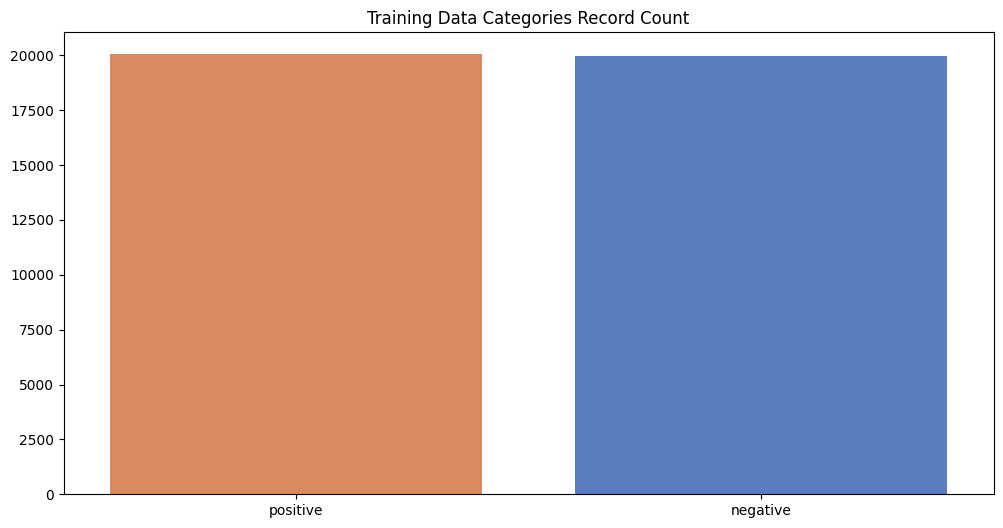

In [10]:
# Distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(x=df_train['sentiment'], order=df_train['sentiment'].value_counts().index, palette="muted", legend=False, hue=df_train['sentiment'])
plt.title('Training Data Categories Record Count')
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Analysis

This data is almost completely balanced between positive and negative sentiment, meaning that we shouldn't have to worry too much about our dataset being biased

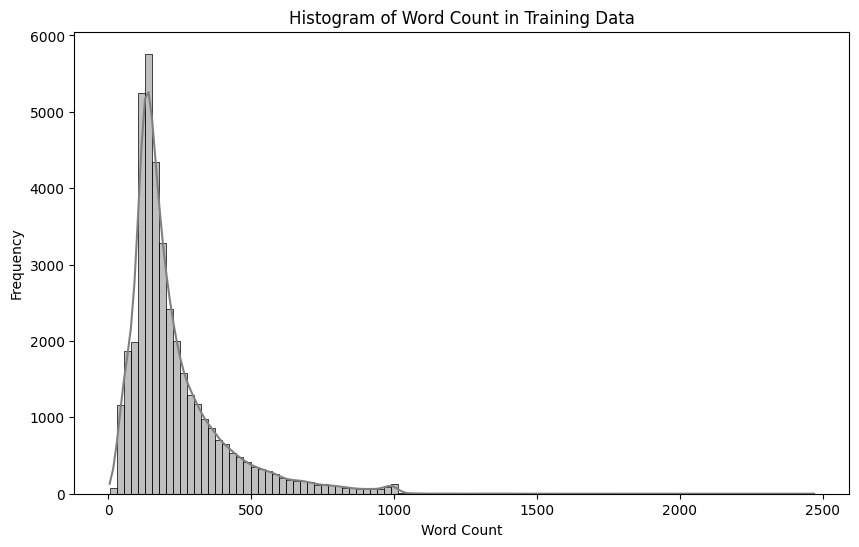

In [12]:
# Check word count distribution
df_train['word_count'] = df_train['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['word_count'], bins=100, kde=True, color='.5')
plt.title('Histogram of Word Count in Training Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Word embedding methods:

- TF-IDF: Uses term frequency and term importance (inverse document frequency) to provide a score
- GloVe: Uses co-occurence statistics of words from a corpus to capture demantic relationahip between words
- Word2Vec: Vectorizes words to capture syntactic and semantic word relationships

We will choose TF-IDF for simplicity and easy usage in Scikit-learn.  This method is supposedly performant and performs well for most text-classification tasks

In [20]:
# Create vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')

# Create TF-IDF matrix by fitting and transforming our training set, creating a row for each article,
#  and a column for each feature (word), and a corresponding value for how important that word is in the model
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['review'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df_train = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

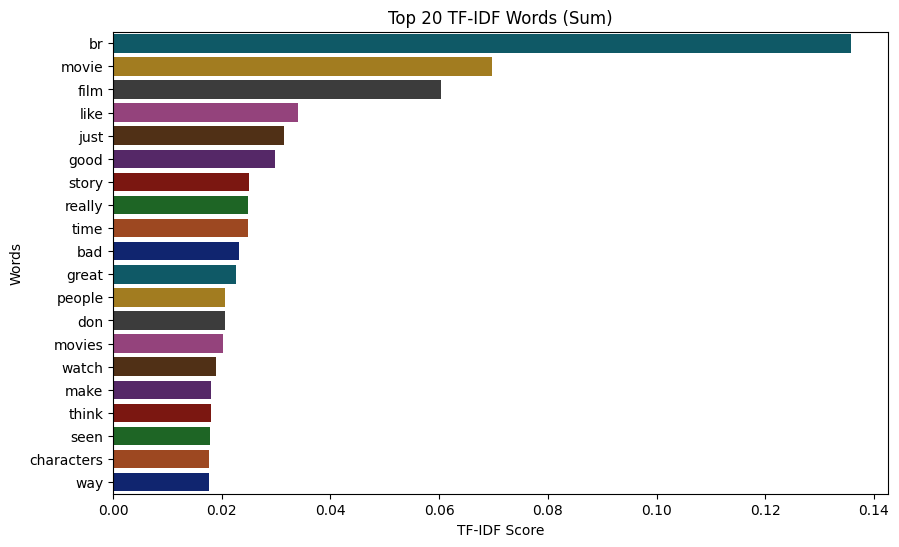

In [21]:
# Get the sum for each feature (word), to get the most important words
tfidf_sum = tfidf_df_train.mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_sum.values, y=tfidf_sum.index, palette="dark", legend=False, hue=tfidf_sum.values)
plt.title('Top 20 TF-IDF Words (Sum)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

tfidf_sum = tfidf_df_train.sum().sort_values(ascending=False).head(50)

#### Analysis

These are the most common words according to our TF-IDF model.  There are a few words here that are potentially problematic.  First off "br" is an artifact of the embedded line break html character <br/>, which provides no value in determining sentiment.  Likewise, words like movie, and film are expected to be find quite frequently, but are neutral terms relating to the subject matter.  We can update our stop words to include these anomolies.

In [25]:
# Update stop words
problematic_words = ['movie', 'movies', 'film', 'films', 'br']
updated_stop_words = list(set(sklearn_stop_words).union(set(problematic_words)))

# Create vectorizer 
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words=updated_stop_words)

# Create TF-IDF matrix by fitting and transforming our training set, creating a row for each article,
#  and a column for each feature (word), and a corresponding value for how important that word is in the model
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['review'])
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df_train = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

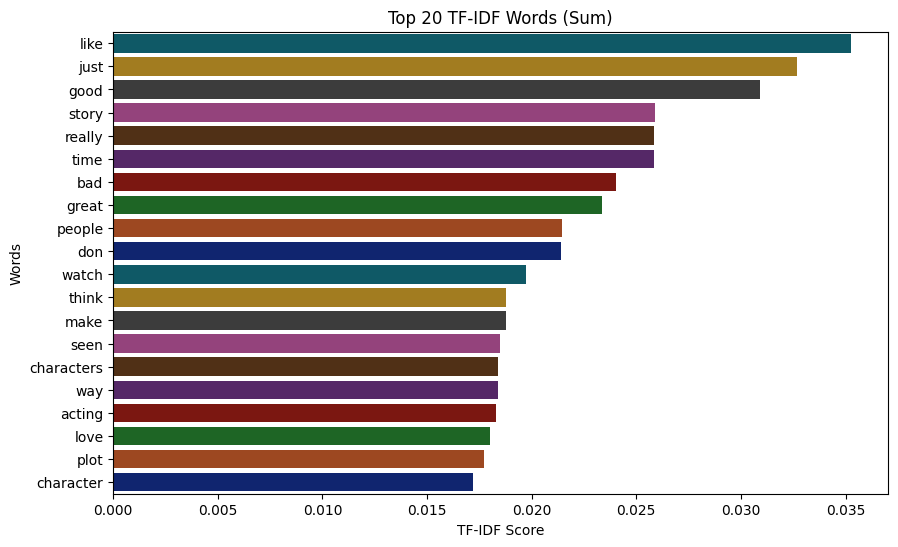

In [26]:
# Get the sum for each feature (word), to get the most important words
tfidf_sum = tfidf_df_train.mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_sum.values, y=tfidf_sum.index, palette="dark", legend=False, hue=tfidf_sum.values)
plt.title('Top 20 TF-IDF Words (Sum)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

tfidf_sum = tfidf_df_train.sum().sort_values(ascending=False).head(50)

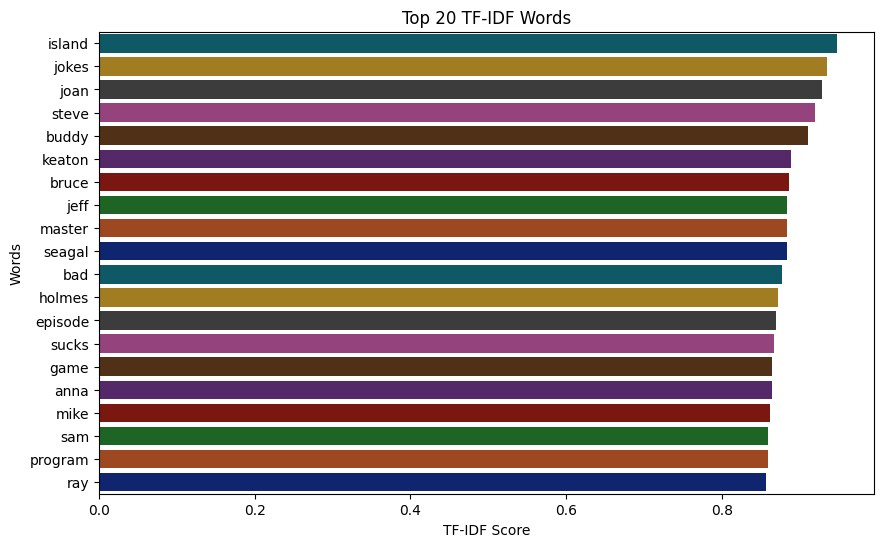

In [27]:
tfidf_sum = tfidf_df_train.max().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_sum.values, y=tfidf_sum.index, palette="dark", legend=False, hue=tfidf_sum.values)
plt.title('Top 20 TF-IDF Words')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.show()

tfidf_sum = tfidf_df_train.sum().sort_values(ascending=False).head(50)

#### Analysis

If we sort words by their "max" value instead rather than the sum of all their values in our TF-IDF Matrix, we got a much more interesting collection of words.  These words are likely a lot less frequent, but we can get a flavor for some of the influential words in our feature set.

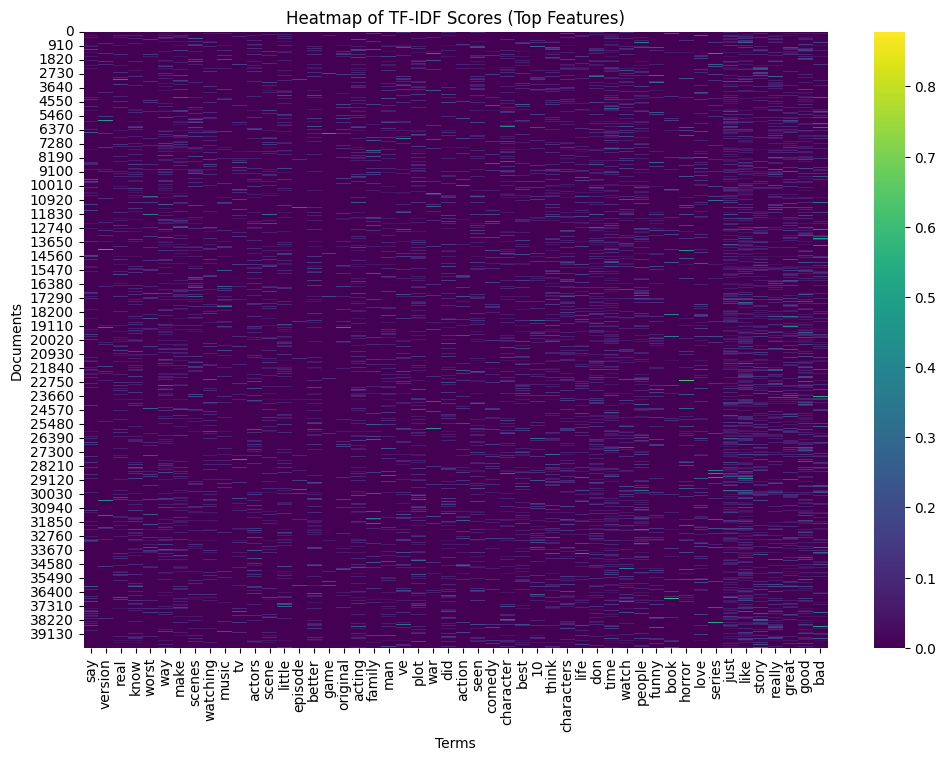

In [29]:
top_n = 50
top_features = np.argsort(tfidf_matrix.toarray().var(axis=0))[-top_n:]

subset_tfidf_matrix = tfidf_matrix[:, top_features]
subset_tfidf_df = pd.DataFrame(subset_tfidf_matrix.toarray(), columns=np.array(feature_names)[top_features])


plt.figure(figsize=(12, 8))
sns.heatmap(subset_tfidf_df, cmap='viridis', cbar=True)
plt.title('Heatmap of TF-IDF Scores (Top Features)')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

In [31]:
# cosine_sim = cosine_similarity(tfidf_matrix)

# cosine_sim_df = pd.DataFrame(cosine_sim, index=df_train.index, columns=df_train.index)

# plt.figure(figsize=(12, 12))
# sns.heatmap(cosine_sim_df, cmap='magma')
# plt.title('Cosine Similarity between Documents')
# plt.show()

### Building and training unsupervised learning models

When we train the unsupervised model for matrix factorization, we will exclude text from the test dataset in order to avoid data leakage.

We've already created our TF-IDF matrix.  Now we can apply Non-Negative Matrix Factorization (NMF) to do topic modeling


In [42]:
sentiment_count = 2

nmf_model = NMF(n_components=sentiment_count, random_state=1)
nmf_model.fit(tfidf_matrix)
nmf_features = nmf_model.transform(tfidf_matrix)
# nmf_features_df = pd.DataFrame(nmf_features, columns=[f"Topic {i}" for i in range(1, nmf_features.shape[1] + 1)])
# print(nmf_features_df.head())

for sentiment_idx, sentiment in enumerate(nmf_model.components_):
    print(f"Topic #{sentiment_idx}:")
    print(" ".join([feature_names[i] for i in sentiment.argsort()[:-10 - 1:-1]]) + ' etc...')
    print()

nmf_features_df = pd.DataFrame(nmf_features, columns=[f"Topic {i}" for i in range(1, nmf_features.shape[1] + 1)])

print(nmf_features_df.head())

Topic #0:
story great love life man character best time characters does etc...

Topic #1:
bad just like really good don watch acting think seen etc...

    Topic 1   Topic 2
0  0.019583  0.014867
1  0.007968  0.012473
2  0.017363  0.022007
3  0.044314  0.005517
4  0.044528  0.009721


df_train.shape (40000, 3)
sentiment_label_mapping: Assigned Sentiment
0    positive
1    negative
dtype: object

[[13732  6224]
 [ 5653 14391]]


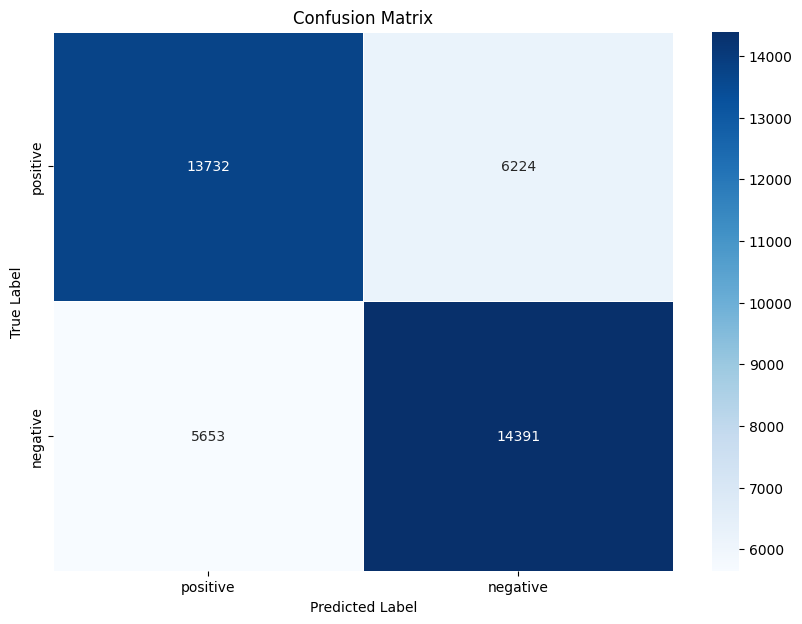

predicted_labels.shape (40000,)


In [43]:
original_texts = df_train['review']
original_categories = df_train['sentiment']
print('df_train.shape', df_train.shape)

sentiments_matrix = nmf_model.transform(tfidf_matrix)

predicted_sentiment = np.argmax(sentiments_matrix, axis=1)

comparison = pd.DataFrame({
    'Assigned Sentiment': predicted_sentiment,
    'True Label': original_categories
})

sentiment_label_distribution = comparison.groupby(['Assigned Sentiment', 'True Label']).size().unstack(fill_value=0)
sentiment_label_mapping = sentiment_label_distribution.idxmax(axis=1)
print('sentiment_label_mapping:', sentiment_label_mapping)

predicted_labels = comparison['Assigned Sentiment'].map(sentiment_label_mapping)
comparison['Predicted Label'] = predicted_labels

print()
cm = confusion_matrix(comparison['True Label'], comparison['Predicted Label'])
print(cm)

conf_matrix_df = pd.DataFrame(cm, index=sentiment_label_mapping.values, columns=sentiment_label_mapping.values)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print('predicted_labels.shape', predicted_labels.shape)



    


### Analysis

There is a high degree of confusion in this matrix, let's see if we can improve this by modifying our hyperparameters

In [52]:
# This code is mostly the same from above, but put into a reusable function

def make_prediction(training_set, test_set, max_features):
    sentiment_count = 2
    
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words=updated_stop_words)

    # Vectorize test and train sets
    tfidf_matrix_train = tfidf_vectorizer.fit_transform(training_set['review'])
    tfidf_matrix_test = tfidf_vectorizer.transform(test_set['review'])

    # Build the NMF
    nmf_model = NMF(n_components=sentiment_count, random_state=1)
    nmf_model.fit(tfidf_matrix_train)
    
    # Transform both the training and test sets
    nmf_features_train = nmf_model.transform(tfidf_matrix_train)
    nmf_features_test = nmf_model.transform(tfidf_matrix_test)


    original_sentiments = training_set['sentiment']

    predicted_sentiments_train = np.argmax(nmf_features_train, axis=1)
    comparison_train = pd.DataFrame({
        'Assigned Sentiment': predicted_sentiments_train,
        'True Label': original_sentiments
    })

    sentiment_label_distribution = comparison.groupby(['Assigned Sentiment', 'True Label']).size().unstack(fill_value=0)
    sentiment_label_mapping = sentiment_label_distribution.idxmax(axis=1)

    # Predict sentiments on the test set using the same mapping
    predicted_sentiments_test = np.argmax(nmf_features_test, axis=1)
    predicted_labels_test = pd.Series(predicted_sentiments_test).map(sentiment_label_mapping)


    true_labels_test = test_set['sentiment']
    accuracy = accuracy_score(true_labels_test, predicted_labels_test)

    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

# make_prediction(df_train, 1000)
    

Accuracy: 0.6975
Accuracy: 0.7071
Accuracy: 0.7094
Accuracy: 0.7104
Accuracy: 0.7113
Accuracy: 0.7123
Accuracy: 0.7123
Accuracy: 0.7127
Accuracy: 0.7130
Accuracy: 0.7133


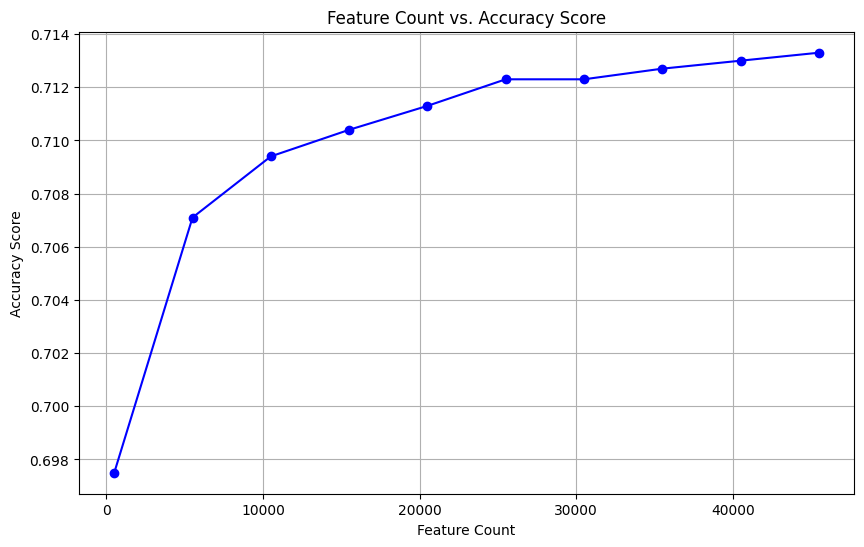

In [57]:
accuracy_scores = []

for feature_count in range(500, 50000, 5000):
    accuracy_scores.append((feature_count, make_prediction(df_train, df_test, feature_count)))

feature_counts = [x[0] for x in accuracy_scores]
accuracy_scores = [x[1] for x in accuracy_scores]

plt.figure(figsize=(10, 6))
plt.plot(feature_counts, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Feature Count vs. Accuracy Score')
plt.xlabel('Feature Count')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.show()

### Analysis

Anything more than around 25000 features basically flattens off and our accuracy no longer increases, but not much than our original test at 2000 features.  Let's compare to supervised learning.

Logistic Regression is a good choice for us, this being a categorization problem.

In [60]:
tfidf_vectorizer = TfidfVectorizer(max_features=20000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review'])

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=1)

# X_test = tfidf_vectorizer.transform(df_test['Text'])

log_reg_model = LogisticRegression(random_state=1)
log_reg_model.fit(X_train, y_train)

y_test_pred = log_reg_model.predict(X_test)

# test_pred_labels = log_reg_model.predict(X_test)

val_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8952


## Result / Summary

We imported the IMDB Movie Ratings database into our project to do sentiment analysis.  The data had no null values that needed to be imputed, and was relatively balanced.  We did a little bit of cleanup of the text data.  

Aftering vectorizing the data using TF-IDF, we created a model using Non-Negative Matrix Factorization, which only performed at only around 70% accuracy.

After utilizing logistc regression, we were able to achieve over 88% accuracy out of the box.